# KMeans Clustering Explainability
In this exercise we will demonstrate the how and why clusters form using KMeans clustering. Using the forest covertypes [dataset](https://scikit-learn.org/stable/datasets/real_world.html#covtype-dataset) from sklearn, we'll apply KMeans clustering to the data, utilize PCA to visualize the clusters, and plot cluster centers to the features. This allows us to feel confident in our understanding of how the features attribute to cluster centers. Lastly, we will assess the stability of the clusters using k-fold cross-validation, revealing how the choice of K influences the robustness of our findings.

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
X, y = fetch_covtype(random_state=42, return_X_y=True, as_frame=True)

# Take an even smaller sample of the data
X = X.sample(frac=0.1, random_state=42)
y = y.loc[X.index]
print("Data shape:", X.shape)

Data shape: (58101, 54)


In [4]:
# How does our numerical data look?
X.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,...,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000,58101.000000
mean,2961.095695,156.183508,14.113045,269.666649,46.146831,2351.007676,212.197690,223.333660,142.471816,1984.694962,...,0.044767,0.091014,0.077744,0.002668,0.003098,0.000138,0.000534,0.026867,0.023528,0.015628
std,279.091350,112.026044,7.475782,212.153471,57.974062,1559.032488,26.746347,19.742694,38.488692,1324.055063,...,0.206793,0.287631,0.267771,0.051582,0.055574,0.011733,0.023093,0.161696,0.151574,0.124032
min,1871.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2810.000000,59.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2997.000000,127.000000,13.000000,218.000000,29.000000,2007.000000,218.000000,226.000000,143.000000,1716.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3165.000000,262.000000,18.000000,390.000000,68.000000,3331.000000,231.000000,237.000000,169.000000,2554.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3846.000000,360.000000,62.000000,1361.000000,597.000000,7087.000000,254.000000,254.000000,253.000000,7145.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Before we use KMeans, we need to standardize the data
# Create a standard scaler object and fit it to the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [6]:
# Let's find the optimal number of clusters using the elbow method
# Run a for loop with k values from 1 to 11, storing the inertia for each k
# Set random_state=42 for reproducibility
# Set the range of k values as a variable k_range so we can plot it later
k_range = range(1, 11)
inertia = []
for k in k_range:
    # Create a KMeans object with k clusters and fit it to the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit the KMeans object to the standardized data
    kmeans.fit(X_std)
    # Append the inertia to the list of inertia
    inertia.append(kmeans.inertia_)

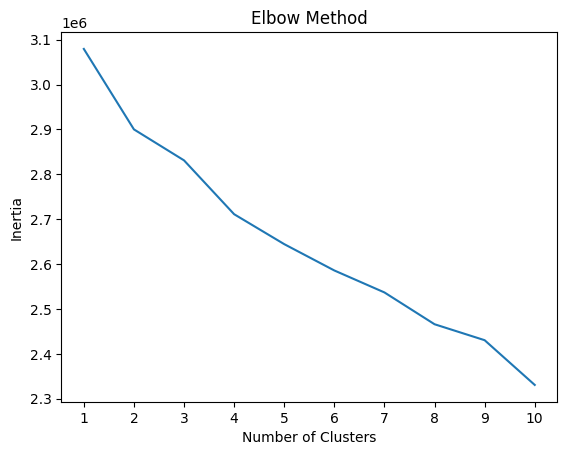

In [7]:
# Plot the inertia as a function of the number of clusters
plt.plot(k_range, inertia)
plt.xticks(k_range)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

#### There doesn't seem to be a clear elbow point, but maybe we can visualize it better with PCA. We will use 4 clusters to keep things simple

In [9]:
# Fit the KMeans model to the data, using 4 clusters and random_state=42
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_std)

KMeans(n_clusters=4, random_state=42)

In [11]:
# We want to visualize the clusters, so we will use PCA to reduce the dimensionality of the data
# Create a PCA object with 10 components and random_state=42
pca = PCA(n_components=4, random_state=42)
# Fit the PCA object to the standardized data
X_pca = pca.fit_transform(X_std)

## Visualizing the Clusters using PCA

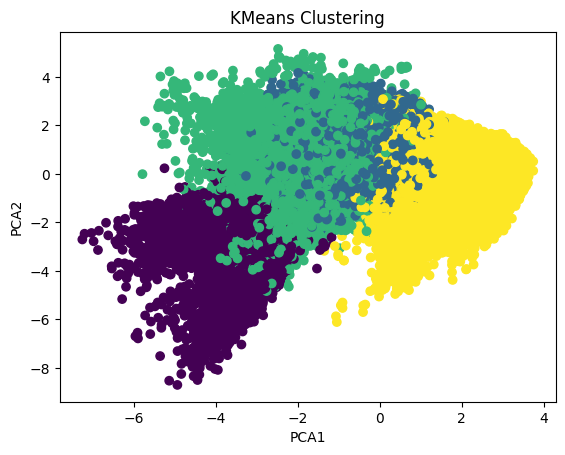

In [13]:
# Now with our PCA data, we can plot the clusters
# Use plt.scatter to plot the PCA data, coloring by the cluster labels
# X_pca will have the 1st and 2nd principal components
# Color the data points with kmeans.labels_ to show the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("KMeans Clustering")
plt.show()

#### The clusters are not clearly separated in the 2D plot. Let's try a 3D plot using the first 3 principal components to see if the clusters are more distinct.

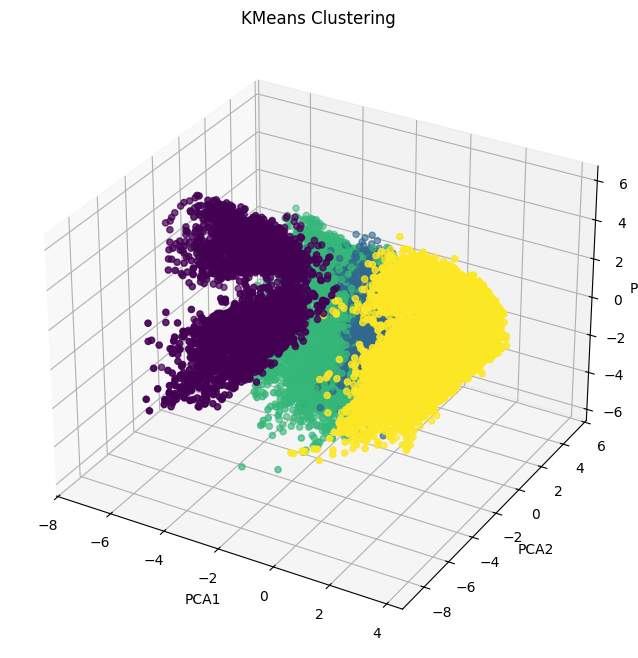

In [15]:
# 3D matplotlib plot of the clusters using the first 3 principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans.labels_)
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("KMeans Clustering")
plt.show()

### This actually looks much better in 3D. We can see that the clusters are more distinct in the 3D plot compared to the 2D plot. This is why it's important to use dimensionality reduction techniques like PCA to visualize high-dimensional data. Let's now plot the cluster centers to understand how the features contribute to the clusters.

## Interpreting the Clusters with Cluster Centers and Feature Names

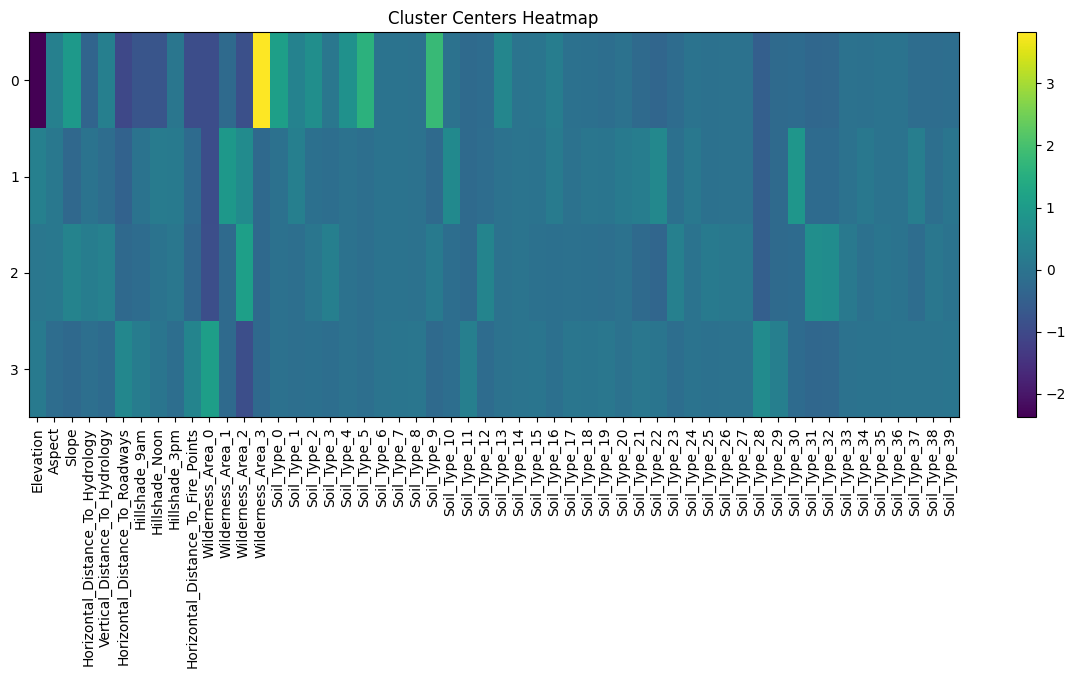

In [16]:
# Plot the cluster centers to understand how the features contribute to the clusters
# Use plt.imshow to plot the cluster centers as a heatmap
plt.figure(figsize=(15, 5))
# Use imshow to plot the cluster centers as a heatmap, using cluster_centers_ from the KMeans object
plt.imshow(kmeans.cluster_centers_, aspect='auto')
# Add the appropriate labels such as feature names and cluster numbers
plt.xticks(range(kmeans.cluster_centers_.shape[1]), X.columns)
plt.yticks(range(kmeans.cluster_centers_.shape[0]))
# Our feature names are long, so we will rotate them for better visibility
plt.xticks(rotation=90)
plt.colorbar()
plt.title("Cluster Centers Heatmap")
plt.show()

#### Any distinct patterns that stand out in the heatmap?

## Calculating Cluster Stability
We decided to use 4 clusters for KMeans, but how do we know if this is the best choice? We can calculate the stability of the clusters using k-fold cross-validation. The stability score is the proportion of consistent assignments across folds. A stability score of 1 indicates perfect stability, while a score of 0 indicates no stability. Let's calculate the stability score for different values of K and see how it changes.

In [17]:
# We already defined a function to calculate the stability score
# If you are interested, read more about stability scores in clustering here:
def calculate_stability(cluster_assignments):
    """
    Calculates a stability score from cluster assignments across folds.

    Args:
        cluster_assignments: A matrix where rows are data points and
                           columns are fold assignments.

    Returns:
        A stability score.
    """
    n_samples, n_folds = cluster_assignments.shape
    consistent_assignments = 0

    for i in range(n_samples):
        most_frequent_cluster = np.argmax(
            np.bincount(cluster_assignments[i, :].astype(int))
        )
        consistent_assignments += np.sum(
            cluster_assignments[i, :] == most_frequent_cluster
        )

    stability_score = consistent_assignments / (n_samples * n_folds)
    return stability_score

In [19]:
# In order to calculate the stability score, we need to use k-fold cross-validation
# We will use 5 folds and store the cluster assignments for each fold, set shuffle=True
n_folds = 5
kf = KFold(n_splits=5, shuffle=True)
# Create an empty matrix to store the cluster assignments
# The matrix should have the same number of rows as the data and n_folds columns
cluster_assignments = np.zeros((X_std.shape[0], n_folds))

In [20]:
# Loop through the folds and store the cluster assignments
# We will use 4 clusters for KMeans, as determined by the work above, and random_state=42
# We will use the standardized data X_std
for fold, (train_index, val_index) in enumerate(kf.split(X_std)):
    X_train, X_val = X_std[train_index], X_std[val_index]
    kmeans = KMeans(n_clusters=4, random_state=42)
    # Fit the KMeans object to the training data
    kmeans.fit(X_train)
    # Store the cluster assignments for the data by using predict
    cluster_assignments[:, fold] = kmeans.predict(X_std)

In [21]:
# Calculate stability score (example: proportion of consistent assignments)
stability_score = calculate_stability(cluster_assignments)
print(f"Stability Score: {stability_score:.3f}")

Stability Score: 0.431


#### This was a good loop through using a K of 4, but let's wrap this into a function to assess the stability of the clusters for different values of K.

In [22]:
# We wrapped the code into a function to assess the stability of the clusters for different values of K
# The silhouette score is also calculated for each fold, and the average is returned
def assess_cluster_stability(std_matrix, n_clusters, n_folds=5, random_state=42):
    """
    Assesses the stability of k-means clustering using k-fold cross-validation.
    The stability score is between 0 and 1, where 1 indicates perfect stability.
    The silhouette score is also calculated for each fold and averaged.

    Args:
        std_matrix: The data matrix, standardized.
        n_clusters: The number of clusters to use.
        n_folds: The number of folds for cross-validation.
        random_state: The random seed for reproducibility.

    Returns:
        tuple of stability score and average silhouette score
    """

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    cluster_assignments = np.zeros((std_matrix.shape[0], n_folds))
    silhouette_avg = 0
    for fold, (train_index, val_index) in enumerate(kf.split(std_matrix)):
        std_matrix_train, std_matrix_val = (
            std_matrix[train_index],
            std_matrix[val_index],
        )
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(std_matrix_train)
        cluster_assignments[:, fold] = kmeans.predict(std_matrix)
        silhouette_avg += silhouette_score(
            std_matrix_val, kmeans.predict(std_matrix_val)
        )

    # Calculate stability score (example: proportion of consistent assignments)
    stability_score = calculate_stability(cluster_assignments)
    # Calculate average silhouette score
    silhouette_avg /= n_folds
    return stability_score, silhouette_avg

In [24]:
# Evaluate the stability for different values of K
for k in range(3, 11):
    # Call the function to assess cluster stability, passing in the standardized data and k
    stability, silhouette_avg = assess_cluster_stability(X_std, n_clusters=k)
    print(
        f"Stability for k={k}: {stability:.3f} | Silhouette Score: {silhouette_avg:.3f}"
    )

Stability for k=3: 0.741 | Silhouette Score: 0.121
Stability for k=4: 0.636 | Silhouette Score: 0.098
Stability for k=5: 0.496 | Silhouette Score: 0.107
Stability for k=6: 0.458 | Silhouette Score: 0.107
Stability for k=7: 0.405 | Silhouette Score: 0.112
Stability for k=8: 0.383 | Silhouette Score: 0.121
Stability for k=9: 0.357 | Silhouette Score: 0.141
Stability for k=10: 0.318 | Silhouette Score: 0.151


## Why does the stability score decrease as K increases?
The stability score decreases as K increases because the clusters become more specific and less general. When K is small, the clusters are more general and capture larger groups of data points. As K increases, the clusters become more specific and capture smaller groups of data points. This specificity can lead to less consistent assignments across folds, resulting in a lower stability score.